In [1]:
import sys
sys.path.append('/home/kyungtak.lim/gbspy')

import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

# Get the current working directory|
cwd = os.getcwd()

In [5]:
os.chdir('/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu1')
s=g.Sim()

t_final = s.time[-1]
t_init = t_final

dens = s.get_field('n', t1=t_init, t2=t_final)
tempe = s.get_field('temperature', t1=t_init, t2=t_final)
pe = dens * tempe
tempi = s.get_field('temperaturi', t1=t_init, t2=t_final)
strmf = s.get_field('strmf', t1=t_init, t2=t_final)
omega = s.get_field('omega', t1=t_init, t2=t_final)
vpari = s.get_field('vpari', t1=t_init, t2=t_final)
vpare = s.get_field('vpari', t1=t_init, t2=t_final)



dens_avg  = np.mean(dens, axis=(2,3)) 
tempe_avg = np.mean(tempe, axis=(2,3))
pe_avg    = np.mean(pe, axis=(2,3))
tempi_avg = np.mean(tempi, axis=(2,3))
strmf_avg = np.mean(strmf, axis=(2,3))
omega_avg = np.mean(omega, axis=(2,3))
vpari_avg = np.mean(vpari, axis=(2,3))
vpare_avg = np.mean(vpare, axis=(2,3))


Xxpt = s.xxpt
Yxpt = s.yxpt
xmag = s.x0
ymag = s.y0
Psi = s.Psi

Bpol = s.dpsidx_v**2 + s.dpsidy_v**2
Xpt_coord = np.unravel_index(np.argmin(Bpol[Bpol > 0]), s.dpsidx_v.shape)

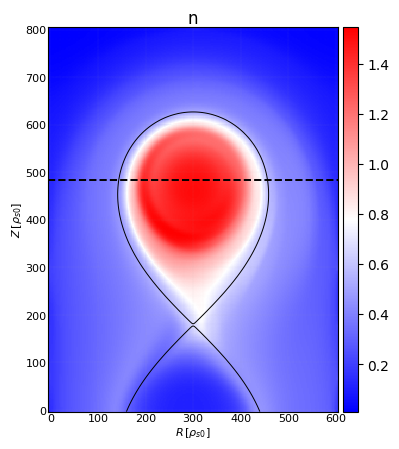

In [18]:
X, Y = np.meshgrid(s.x, s.y)
fig, ax = plt.subplots(figsize=(4, 5), sharex=True, sharey=True)

cs1 = ax.pcolormesh(X, Y, dens_avg, cmap='bwr')
#cs1 = ax.pcolormesh(X, Y, dens_avg, cmap='bwr')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar=fig.colorbar(cs1, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)


ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], linewidths=0.7, colors='k')
ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
ax.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', labelsize=8, pad=1)
ax.tick_params(axis='y', labelsize=8, pad=1)
ax.tick_params(which='minor', direction="in", size=0)
ax.tick_params(which='major', direction="in", size=0)


ax.axhline(y=s.y0, color='k', linestyle='--', linewidth=1.4)

ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=8, labelpad=1)
ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=8, rotation=90, labelpad=1)

ax.set_title(r'n', fontsize=12, pad=1.5)

#plt.gca().set_aspect('equal')
plt.show(block=False)

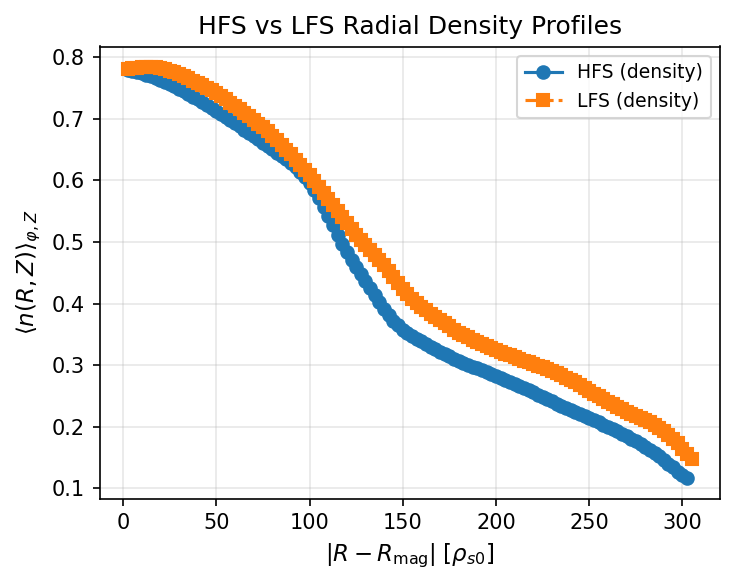

In [19]:
#r_HFS, prof_HFS_n, r_LFS, prof_LFS_n = hfs_lfs_radial_profiles(dens_avg, x, xmag, y=y)

# Electron temperature
r_HFS_Te, prof_HFS_Te, r_LFS_Te, prof_LFS_Te = hfs_lfs_radial_profiles(tempe_avg, x, xmag)

# Electron pressure
r_HFS_pe, prof_HFS_pe, r_LFS_pe, prof_LFS_pe = hfs_lfs_radial_profiles(pe_avg, x, xmag)

# Vorticity
r_HFS_om, prof_HFS_om, r_LFS_om, prof_LFS_om = hfs_lfs_radial_profiles(omega_avg, x, xmag)



fig2, ax2 = plt.subplots(figsize=(5, 4), dpi=150)

ax2.plot(r_HFS, prof_HFS_n, 'o-', label='HFS (density)')
ax2.plot(r_LFS, prof_LFS_n, 's--', label='LFS (density)')

#ax2.plot(r_HFS, prof_HFS_pe, 'o-', label='HFS (density)')
#ax2.plot(r_LFS, prof_LFS_pe, 's--', label='LFS (density)')


ax2.set_xlabel(r'$|R - R_{\mathrm{mag}}| \; [\rho_{s0}]$', fontsize=11)
ax2.set_ylabel(r'$\langle n(R,Z) \rangle_{\varphi,Z}$', fontsize=11)
ax2.set_title(r'HFS vs LFS Radial Density Profiles', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9, loc='best')

plt.tight_layout()
plt.show()

# Define function

In [20]:
def hfs_lfs_radial_profiles(field_avg, x, xmag, y=None):
    """
    Compute HFS/LFS radial profiles for a toroidally averaged quantity.

    Parameters
    ----------
    field_avg : 2D array (ny, nx)
        Toroidally (and possibly temporally) averaged field, e.g. dens_avg.
    x : 1D array (nx,)
        Radial grid (R).
    xmag : float
        Magnetic axis radial coordinate R_mag = s.x0.
    y : 1D array (ny,), optional
        Poloidal grid (Z). Not used explicitly; only the field is averaged over axis 0.

    Returns
    -------
    r_HFS : 1D array
        Radial coordinate |R - R_mag| on the HFS side (increasing away from axis).
    prof_HFS : 1D array
        Poloidally averaged HFS profile vs r_HFS.
    r_LFS : 1D array
        Radial coordinate |R - R_mag| on the LFS side (increasing away from axis).
    prof_LFS : 1D array
        Poloidally averaged LFS profile vs r_LFS.
    """
    ny, nx = field_avg.shape

    # 1) Index of magnetic axis in R
    ix_mag = np.argmin(np.abs(x - xmag))

    # 2) Split into HFS (R < xmag) and LFS (R > xmag)
    field_HFS_2D = field_avg[:, :ix_mag]      # (ny, nx_HFS)
    x_HFS        = x[:ix_mag]

    field_LFS_2D = field_avg[:, ix_mag+1:]    # (ny, nx_LFS)
    x_LFS        = x[ix_mag+1:]

    # 3) Poloidal average -> radial profiles
    prof_HFS = field_HFS_2D.mean(axis=0)      # vs x_HFS
    prof_LFS = field_LFS_2D.mean(axis=0)      # vs x_LFS

    # 4) Symmetric radial coordinate relative to magnetic axis
    r_HFS = (xmag - x_HFS)[::-1]              # positive, outward from axis
    prof_HFS_sym = prof_HFS[::-1]             # flip to match increasing r_HFS

    r_LFS = x_LFS - xmag                      # positive, outward from axis
    prof_LFS_sym = prof_LFS

    return r_HFS, prof_HFS_sym, r_LFS, prof_LFS_sym
